In [1]:
# Install all required libraries
!pip install ultralytics opencv-python opendatasets streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 50.1 MB/s eta 0:00:00
  Attempting uninstall: cachetools
    Found existing installation: cachetools 7.0.0
    Uninstalling cachetools-7.0.0:
      Successfully uninstalled cachetools-7.0.0


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/hard-hat-detection")

print("Path to dataset files:", path)

100%|██████████| 1.22G/1.22G [00:10<00:00, 122MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/hard-hat-detection/versions/1


In [3]:
import os
import xml.etree.ElementTree as ET
import pandas as pd

def parse_xml(xml_path):
    """Parses a single XML file and returns a list of objects."""
    tree = ET.parse(xml_path)
    root = tree.getroot()

    width = int(root.find('size').find('width').text)
    height = int(root.find('size').find('height').text)

    objects = []
    for obj in root.findall('object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')

        # Coordinates
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        objects.append({
            'filename': root.find('filename').text,
            'width': width,
            'height': height,
            'class': label,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax
        })
    return objects

# Define your paths based on the kagglehub output
dataset_path = '/root/.cache/kagglehub/datasets/andrewmvd/hard-hat-detection/versions/1'
annotations_path = os.path.join(dataset_path, 'annotations')

# Process all files
all_objects = []
for xml_file in os.listdir(annotations_path):
    if xml_file.endswith('.xml'):
        all_objects.extend(parse_xml(os.path.join(annotations_path, xml_file)))

# Create a DataFrame for easy manipulation
df = pd.DataFrame(all_objects)

# Quick look at the class distribution
print(df['class'].value_counts())
print(df.head())

class
helmet    18966
head       5785
person      751
Name: count, dtype: int64
                  filename  width  height   class  xmin  ymin  xmax  ymax
0  hard_hat_workers194.png    416     415  helmet   300   105   372   188
1  hard_hat_workers194.png    416     415  helmet   141   141   163   169
2  hard_hat_workers194.png    416     415  helmet    90   156   109   171
3  hard_hat_workers194.png    416     415  helmet    31   178    50   201
4  hard_hat_workers194.png    416     415  helmet    40   146    59   165


In [4]:
import os
import xml.etree.ElementTree as ET
import shutil
from sklearn.model_selection import train_test_split

# Setup paths
base_path = '/root/.cache/kagglehub/datasets/andrewmvd/hard-hat-detection/versions/1'
images_path = os.path.join(base_path, 'images')
annotations_path = os.path.join(base_path, 'annotations')

# Map your XML classes to IDs
classes = ['helmet', 'head', 'person']
class_map = {name: i for i, name in enumerate(classes)}

def convert_to_yolo(size, box):
    dw = 1./size[0]
    dh = 1./size[1]
    x = (box[0] + box[1])/2.0
    y = (box[2] + box[3])/2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    return (x*dw, y*dh, w*dw, h*dh)

# Create YOLO structure
os.makedirs('dataset/images/train', exist_ok=True)
os.makedirs('dataset/images/val', exist_ok=True)
os.makedirs('dataset/labels/train', exist_ok=True)
os.makedirs('dataset/labels/val', exist_ok=True)

all_imgs = [f for f in os.listdir(images_path) if f.endswith('.png')]
train_imgs, val_imgs = train_test_split(all_imgs, test_size=0.2, random_state=42)

def process_set(img_list, set_name):
    for img_name in img_list:
        # Move image
        shutil.copy(os.path.join(images_path, img_name), f'dataset/images/{set_name}/{img_name}')

        # Convert XML to TXT
        xml_name = img_name.replace('.png', '.xml')
        tree = ET.parse(os.path.join(annotations_path, xml_name))
        root = tree.getroot()
        size = root.find('size')
        w, h = int(size.find('width').text), int(size.find('height').text)

        with open(f'dataset/labels/{set_name}/{img_name.replace(".png", ".txt")}', 'w') as f:
            for obj in root.findall('object'):
                cls = obj.find('name').text
                if cls not in classes: continue
                xmlbox = obj.find('bndbox')
                b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text),
                     float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
                bb = convert_to_yolo((w, h), b)
                f.write(f"{class_map[cls]} {' '.join([f'{a:.6f}' for a in bb])}\n")

process_set(train_imgs, 'train')
process_set(val_imgs, 'val')

print("Preprocessing complete!")

Preprocessing complete!


In [5]:
yaml_content = f"""
path: {os.getcwd()}/dataset  # The absolute path to your dataset folder
train: images/train
val: images/val

names:
  0: helmet
  1: head
  2: person
"""

with open('helmet_data.yaml', 'w') as f:
    f.write(yaml_content)

print("helmet_data.yaml created!")

helmet_data.yaml created!


In [6]:
# Install the library
!pip install ultralytics

from ultralytics import YOLO

# 1. Load a pretrained YOLOv8 Nano model
model = YOLO('yolov8n.pt')

# 2. Train the model
# epochs=25 is a good start to see progress without waiting hours
# imgsz=640 is the standard size for these models
results = model.train(
    data='helmet_data.yaml',
    epochs=25,
    imgsz=640,
    batch=16,
    name='helmet_model'
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.4.12 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=helmet_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=

Please upload an image for helmet detection:


Saving img3.jpg to img3.jpg

image 1/1 /content/img3.jpg: 448x640 1 head, 9.4ms
Speed: 2.4ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)
------------------------------
❌ Prediction: No helmet detected.
------------------------------
Detection Results:


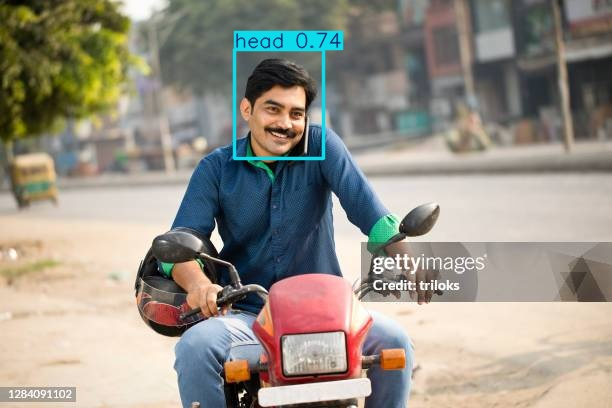

In [9]:
from ultralytics import YOLO
from google.colab import files
import cv2
from google.colab.patches import cv2_imshow
import os

# 1. Load your trained model
# Ensure this path matches where your model was saved
model_path = 'runs/detect/helmet_model/weights/best.pt'
model = YOLO(model_path)

# 2. Upload an image
print("Please upload an image for helmet detection:")
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# 3. Run Prediction
# conf=0.5 means only show detections with 50% confidence or higher
results = model.predict(source=image_path, conf=0.5)

# 4. Analyze Results
# The model returns a list of result objects, we take the first one
result = results[0]

has_helmet = False
for box in result.boxes:
    class_id = int(box.cls[0])
    class_name = result.names[class_id]

    if class_name == 'helmet':
        has_helmet = True
        break

# 5. Output Result
print("-" * 30)
if has_helmet:
    print("✅ Prediction: Person is wearing a helmet.")
else:
    print("❌ Prediction: No helmet detected.")
print("-" * 30)

# Optional: Display the image with bounding boxes
print("Detection Results:")
# This saves a plot to a temporary folder and displays it
result.save(filename='result.jpg')
cv2_imshow(cv2.imread('result.jpg'))